# Laboratorio 8 - Deep Learning y sistemas inteligentes
### Repo: https://github.com/SebasJuarez/StoreItemDemand
### Sebastian Juárez - 21471
### Javier Prado - 21486
### Bryan España - 21550

### Preparación

In [1]:
import os, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
warnings.filterwarnings("ignore")


SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATA_DIR = "./Data"
TRAIN_PATH = os.path.join(DATA_DIR, "train.csv")
TEST_PATH  = os.path.join(DATA_DIR, "test.csv")

HORIZON_DAYS = 90
WINDOW_SIZE  = 180
MIN_SERIES_LEN = WINDOW_SIZE + HORIZON_DAYS + 1


### Preparación de datos

#### Limpieza de celdas

In [2]:
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

train["date"] = pd.to_datetime(train["date"])
train = train.sort_values(["store","item","date"]).reset_index(drop=True)


print(train.head())
print(train.isna().sum())


if train["sales"].isna().any():
    train["sales"] = train["sales"].fillna(0)

def winsorize_series(s, k=1.5):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lo, hi = q1 - k*iqr, q3 + k*iqr
    return s.clip(lower=lo, upper=hi)

train["sales_w"] = (
    train.groupby(["store","item"])["sales"]
         .transform(lambda s: winsorize_series(s))
)

train["sales_log"] = np.log1p(train["sales_w"])


        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10
date     0
store    0
item     0
sales    0
dtype: int64


#### Transformaciones

In [3]:
train["dow"]   = train["date"].dt.dayofweek
train["month"] = train["date"].dt.month

train["dow_s"]   = train["dow"]   / 6.0
train["month_s"] = (train["month"] - 1) / 11.0

feat_cols = ["sales_log", "dow_s", "month_s"]
key_cols  = ["store","item","date"]
data = train[key_cols + feat_cols].copy()
data.head()


,store,item,date,sales_log,dow_s,month_s
0,1,1,2013-01-01,2.639057,0.166667,0.0
1,1,1,2013-01-02,2.484907,0.333333,0.0
2,1,1,2013-01-03,2.708050,0.500000,0.0
3,1,1,2013-01-04,2.639057,0.666667,0.0
4,1,1,2013-01-05,2.397895,0.833333,0.0


### Preprocesamiento

In [4]:
last_date = data["date"].max()
val_start = last_date - pd.Timedelta(days=HORIZON_DAYS-1)

print("Última fecha:", last_date.date(), "| Inicio de valid:", val_start.date())

data["split"] = np.where(data["date"] >= val_start, "valid", "train")

Última fecha: 2017-12-31 | Inicio de valid: 2017-10-03


In [5]:
def build_sequences(df_one_series, window=WINDOW_SIZE, horizon=HORIZON_DAYS):
    feats = df_one_series[feat_cols].values
    dates = df_one_series["date"].values
    splits = df_one_series["split"].values

    X_tr, y_tr, X_va, y_va = [], [], [], []

    for start in range(0, len(df_one_series) - (window + horizon) + 1):
        end_w = start + window
        end_h = end_w + horizon

        X_win = feats[start:end_w]
        y_win = df_one_series["sales_log"].values[end_w:end_h]

        target_last_date = df_one_series["date"].iloc[end_h - 1]
        if target_last_date >= val_start:
            X_va.append(X_win)
            y_va.append(y_win)
        else:
            X_tr.append(X_win)
            y_tr.append(y_win)

    return X_tr, y_tr, X_va, y_va

X_train, y_train, X_valid, y_valid = [], [], [], []

for (st, it), g in data.groupby(["store","item"]):
    g = g.sort_values("date")
    if len(g) < MIN_SERIES_LEN:
        continue
    Xt, yt, Xv, yv = build_sequences(g)
    if Xt:
        X_train.extend(Xt)
        y_train.extend(yt)
    if Xv:
        X_valid.extend(Xv)
        y_valid.extend(yv)

X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_valid = np.array(X_valid, dtype=np.float32)
y_valid = np.array(y_valid, dtype=np.float32)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((733500, 180, 3), (733500, 90), (45000, 180, 3), (45000, 90))

### Filtrado para la seleccion de datos

In [15]:
QUICK_MODE = True
USE_CONV1D = True
LAST_WINDOWS_PER_SERIES = 8
NEW_WINDOW_SIZE = 90
EPOCHS_TURBO = 50
PATIENCE_TURBO = 7
BATCH_SIZE_TURBO = 128

if QUICK_MODE:
    try:
        WINDOW_SIZE = NEW_WINDOW_SIZE
    except NameError:
        pass

    def take_tail_by_blocks(X, y, k=LAST_WINDOWS_PER_SERIES, block=10_000):
        keep = min(len(X), max(k, (len(X)//block)*k + k))
        return X[-keep:], y[-keep:]
    X_train, y_train = take_tail_by_blocks(X_train, y_train, LAST_WINDOWS_PER_SERIES)

    MODEL_KIND = "CONV1D" if USE_CONV1D else "LSTM"

    print(f"[TURBO] X_train: {X_train.shape} | X_valid: {X_valid.shape}")
    print(f"[TURBO] Usando MODEL_KIND={MODEL_KIND}, epochs={EPOCHS_TURBO}, batch={BATCH_SIZE_TURBO}, patience={PATIENCE_TURBO}")


[TURBO] X_train: (4, 180, 3) | X_valid: (45000, 180, 3)
[TURBO] Usando MODEL_KIND=CONV1D, epochs=50, batch=128, patience=7


### Modelado - CONV1D

In [16]:
if 'BACKEND' not in globals() or BACKEND != 'torch':
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers

    n_timesteps = X_train.shape[1]
    n_features  = X_train.shape[2]
    n_outputs   = y_train.shape[1]

    def build_conv1d_fast(timesteps, nfeat, horizon):
        inputs = keras.Input(shape=(timesteps, nfeat))
        x = layers.Conv1D(96, kernel_size=7, padding="causal", activation="relu")(inputs)
        x = layers.Conv1D(96, kernel_size=7, padding="causal", activation="relu")(x)
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Conv1D(128, kernel_size=5, padding="causal", activation="relu")(x)
        x = layers.GlobalAveragePooling1D()(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(128, activation="relu")(x)
        outputs = layers.Dense(horizon, activation="linear")(x)
        return keras.Model(inputs, outputs, name="conv1d_fast")

    if MODEL_KIND == "CONV1D":
        model = build_conv1d_fast(n_timesteps, n_features, n_outputs)
    else:
        pass

    model.summary()


Model: "conv1d_fast"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 3)]          0         
                                                                 
 conv1d_6 (Conv1D)           (None, 180, 96)           2112      
                                                                 
 conv1d_7 (Conv1D)           (None, 180, 96)           64608     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 90, 96)            0         
 g1D)                                                            
                                                                 
 conv1d_8 (Conv1D)           (None, 90, 128)           61568     
                                                                 
 global_average_pooling1d_2  (None, 128)               0         
  (GlobalAveragePooling1D)                             

In [17]:
if 'BACKEND' not in globals() or BACKEND != 'torch':
    import tensorflow as tf
    from tensorflow import keras

    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse", metrics=["mae"])
    cbs = [
        keras.callbacks.EarlyStopping(patience=PATIENCE_TURBO, restore_best_weights=True, monitor="val_loss"),
        keras.callbacks.ReduceLROnPlateau(patience=1, factor=0.5, min_lr=1e-5),
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=EPOCHS_TURBO,
        batch_size=BATCH_SIZE_TURBO,
        verbose=1,
        callbacks=cbs
    )


Epoch 1/50
1/1 [==============================] - 7s 7s/step - loss: 20.8377 - mae: 4.5581 - val_loss: 15.9077 - val_mae: 3.9494 - lr: 0.0010
Epoch 2/50
1/1 [==============================] - 6s 6s/step - loss: 20.2979 - mae: 4.4988 - val_loss: 15.5112 - val_mae: 3.8967 - lr: 0.0010
Epoch 3/50
1/1 [==============================] - 6s 6s/step - loss: 19.7587 - mae: 4.4349 - val_loss: 14.8842 - val_mae: 3.8086 - lr: 0.0010
Epoch 4/50
1/1 [==============================] - 6s 6s/step - loss: 19.1070 - mae: 4.3521 - val_loss: 13.9423 - val_mae: 3.6670 - lr: 0.0010
Epoch 5/50
1/1 [==============================] - 6s 6s/step - loss: 17.8153 - mae: 4.1783 - val_loss: 12.6684 - val_mae: 3.4525 - lr: 0.0010
Epoch 6/50
1/1 [==============================] - 6s 6s/step - loss: 16.3717 - mae: 3.9639 - val_loss: 11.1218 - val_mae: 3.1389 - lr: 0.0010
Epoch 7/50
1/1 [==============================] - 6s 6s/step - loss: 14.3310 - mae: 3.5667 - val_loss: 9.4890 - val_mae: 2.7095 - lr: 0.0010
Epoch 8

In [ ]:
import numpy as np

def rmse(a, b):
    return float(np.sqrt(np.mean((a - b)**2)))

def mae(a, b):
    return float(np.mean(np.abs(a - b)))

if 'BACKEND' in globals() and BACKEND == "torch":
    import torch
    model_torch.eval()
    with torch.no_grad():
        Xv_t = torch.tensor(X_valid, dtype=torch.float32).to(DEVICE)
        yv_pred = model_torch(Xv_t).cpu().numpy()
    yv_true = y_valid.copy()
else:
    yv_pred = model.predict(X_valid, verbose=0)
    yv_true = y_valid.copy()

mae_log  = mae(yv_true, yv_pred)
rmse_log = rmse(yv_true, yv_pred)

yv_true_lin = np.expm1(yv_true)
yv_pred_lin = np.expm1(yv_pred).clip(min=0.0)

mae_lin  = mae(yv_true_lin, yv_pred_lin)
rmse_lin = rmse(yv_true_lin, yv_pred_lin)

print(f"VALID (log1p):   MAE={mae_log:.4f} | RMSE={rmse_log:.4f}")
print(f"VALID (lineal):  MAE={mae_lin:.2f} | RMSE={rmse_lin:.2f}")


VALID (log1p):   MAE=0.3587 | RMSE=0.4472
VALID (lineal):  MAE=24.26 | RMSE=36.56


### Ajuste de Híperparametros

In [ ]:
import numpy as np
import pandas as pd

WINDOW_SIZE = globals().get("WINDOW_SIZE", 90)
HORIZON     = globals().get("HORIZON_DAYS", 90)

last_date = pd.to_datetime(data["date"]).max()
VAL_BUFFER_DAYS = 0
val_start = last_date - pd.Timedelta(days=HORIZON - 1 + VAL_BUFFER_DAYS)

def build_k_split_sequences(df_one_series, window=WINDOW_SIZE, horizon=HORIZON, k_train=8, k_valid=8):
    g = df_one_series.sort_values("date").reset_index(drop=True)
    n = len(g)
    max_start = n - (window + horizon)
    if max_start < 0:
        return [], [], [], []
    starts = list(range(0, max_start + 1))
    feats = g[feat_cols].values

    def last_target_date(s):
        return pd.to_datetime(g["date"].iloc[s + window + horizon - 1])

    train_starts = [s for s in starts if last_target_date(s) <  val_start]
    valid_starts = [s for s in starts if last_target_date(s) >= val_start]
    train_starts = train_starts[-k_train:]
    valid_starts = valid_starts[-k_valid:]

    X_tr, y_tr, X_va, y_va = [], [], [], []
    for s in train_starts:
        e_w, e_h = s + window, s + window + horizon
        X_tr.append(feats[s:e_w]); y_tr.append(g["sales_log"].values[e_w:e_h])
    for s in valid_starts:
        e_w, e_h = s + window, s + window + horizon
        X_va.append(feats[s:e_w]); y_va.append(g["sales_log"].values[e_w:e_h])
    return X_tr, y_tr, X_va, y_va

K_TRAIN = 8
K_VALID = 8

X_train, y_train, X_valid, y_valid = [], [], [], []
for (st, it), g in data.groupby(["store","item"]):
    Xt, yt, Xv, yv = build_k_split_sequences(g, k_train=K_TRAIN, k_valid=K_VALID)
    if Xt: X_train += Xt; y_train += yt
    if Xv: X_valid += Xv; y_valid += yv

X_train = np.asarray(X_train, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.float32)
X_valid = np.asarray(X_valid, dtype=np.float32)
y_valid = np.asarray(y_valid, dtype=np.float32)

print("feat_cols usados:", feat_cols)
print("val_start:", val_start.date())
print("Shapes ->", X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)


feat_cols usados: ['sales_log', 'sin_w', 'cos_w']
val_start: 2017-10-03
Shapes -> (4000, 90, 3) (4000, 90) (4000, 90, 3) (4000, 90)


#### Elección de la mejor configuración

In [ ]:
import numpy as np, pandas as pd, math, time, random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

SEED = 42
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

def build_conv1d_fast(n_timesteps, n_features, horizon, 
                      f1=96, f2=96, f3=128, k1=7, k2=7, k3=5, 
                      dense=128, drop=0.2):
    inp = keras.Input(shape=(n_timesteps, n_features))
    x = layers.Conv1D(f1, k1, padding="causal", activation="relu")(inp)
    x = layers.Conv1D(f2, k2, padding="causal", activation="relu")(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(f3, k3, padding="causal", activation="relu")(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(drop)(x)
    x = layers.Dense(dense, activation="relu")(x)
    out = layers.Dense(horizon, activation="linear")(x)
    return keras.Model(inp, out)

def mae(a,b):  return float(np.mean(np.abs(a-b)))
def rmse(a,b): return float(np.sqrt(np.mean((a-b)**2)))

space = {
    "f1":   [64, 96, 128],
    "f2":   [64, 96, 128],
    "f3":   [96, 128, 160],
    "k1":   [5, 7, 9],
    "k2":   [5, 7, 9],
    "k3":   [3, 5, 7],
    "dense":[64, 128, 192],
    "drop": [0.1, 0.2, 0.3],
    "lr":   [1e-3, 7e-4, 5e-4],
    "batch":[64, 128, 256],
    "epochs":[12, 16, 20],
}

def sample(space):
    return {k: random.choice(v) for k,v in space.items()}

def try_cfg(cfg):
    nT, nF, nO = X_train.shape[1], X_train.shape[2], y_train.shape[1]
    model = build_conv1d_fast(nT, nF, nO,
                              f1=cfg["f1"], f2=cfg["f2"], f3=cfg["f3"],
                              k1=cfg["k1"], k2=cfg["k2"], k3=cfg["k3"],
                              dense=cfg["dense"], drop=cfg["drop"])
    model.compile(optimizer=keras.optimizers.Adam(cfg["lr"]), loss="mse", metrics=["mae"])
    cbs = [keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True, monitor="val_loss")]
    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=cfg["epochs"],
        batch_size=cfg["batch"],
        verbose=0,
        callbacks=cbs
    )
    yvp = model.predict(X_valid, verbose=0)
    m_log, r_log = mae(y_valid, yvp), rmse(y_valid, yvp)
    m_lin = mae(np.expm1(y_valid), np.expm1(yvp).clip(min=0))
    r_lin = rmse(np.expm1(y_valid), np.expm1(yvp).clip(min=0))
    return model, {"mae_log":m_log, "rmse_log":r_log, "mae_lin":m_lin, "rmse_lin":r_lin}

N_TRIALS = 8
results = []
best = {"score": float("inf"), "cfg": None, "model": None}

t0 = time.time()
for t in range(1, N_TRIALS+1):
    cfg = sample(space)
    model, metrics = try_cfg(cfg)
    score = metrics["mae_lin"]
    results.append({**cfg, **metrics})
    print(f"[{t}/{N_TRIALS}] MAE_lin={score:.2f} | cfg={cfg}")
    if score < best["score"]:
        best.update(score=score, cfg=cfg, model=model)

res_df = pd.DataFrame(results).sort_values("mae_lin").reset_index(drop=True)
print(f"\nDuración: {time.time()-t0:.1f}s")
display(res_df.head(10))
print("\nMejor config:", best["cfg"], "| MAE(lineal)=", round(best["score"],2))
res_df.to_csv("tuning_results_conv1d.csv", index=False)


[1/8] MAE_lin=11.78 | cfg={'f1': 128, 'f2': 64, 'f3': 96, 'k1': 9, 'k2': 7, 'k3': 3, 'dense': 64, 'drop': 0.1, 'lr': 0.0005, 'batch': 64, 'epochs': 20}
[2/8] MAE_lin=9.86 | cfg={'f1': 128, 'f2': 128, 'f3': 96, 'k1': 9, 'k2': 7, 'k3': 3, 'dense': 64, 'drop': 0.1, 'lr': 0.001, 'batch': 64, 'epochs': 20}
[3/8] MAE_lin=11.26 | cfg={'f1': 128, 'f2': 64, 'f3': 160, 'k1': 5, 'k2': 9, 'k3': 7, 'dense': 192, 'drop': 0.3, 'lr': 0.0007, 'batch': 64, 'epochs': 16}
[4/8] MAE_lin=9.96 | cfg={'f1': 128, 'f2': 96, 'f3': 96, 'k1': 5, 'k2': 9, 'k3': 5, 'dense': 128, 'drop': 0.2, 'lr': 0.001, 'batch': 64, 'epochs': 16}
[5/8] MAE_lin=12.00 | cfg={'f1': 64, 'f2': 64, 'f3': 128, 'k1': 5, 'k2': 7, 'k3': 5, 'dense': 192, 'drop': 0.2, 'lr': 0.001, 'batch': 256, 'epochs': 16}
[6/8] MAE_lin=10.20 | cfg={'f1': 128, 'f2': 64, 'f3': 128, 'k1': 5, 'k2': 9, 'k3': 5, 'dense': 192, 'drop': 0.3, 'lr': 0.0007, 'batch': 256, 'epochs': 12}
[7/8] MAE_lin=10.69 | cfg={'f1': 128, 'f2': 64, 'f3': 96, 'k1': 9, 'k2': 5, 'k3': 5,

,f1,f2,f3,k1,k2,k3,dense,drop,lr,batch,epochs,mae_log,rmse_log,mae_lin,rmse_lin
0,96,128,128,5,7,5,64,0.3,0.0007,256,20,0.184755,0.236809,9.591046,12.673179
1,128,128,96,9,7,3,64,0.1,0.0010,64,20,0.185612,0.232453,9.858884,13.474276
2,128,96,96,5,9,5,128,0.2,0.0010,64,16,0.188289,0.237254,9.957975,13.552837
3,128,64,128,5,9,5,192,0.3,0.0007,256,12,0.193142,0.244793,10.197189,13.952500
4,128,64,96,9,5,5,64,0.1,0.0010,128,16,0.206501,0.265636,10.692445,13.780152
5,128,64,160,5,9,7,192,0.3,0.0007,64,16,0.211034,0.268341,11.256397,15.137669
6,128,64,96,9,7,3,64,0.1,0.0005,64,20,0.223299,0.284667,11.783048,15.097117
7,64,64,128,5,7,5,192,0.2,0.0010,256,16,0.223060,0.284225,11.995338,15.962681



Mejor config: {'f1': 96, 'f2': 128, 'f3': 128, 'k1': 5, 'k2': 7, 'k3': 5, 'dense': 64, 'drop': 0.3, 'lr': 0.0007, 'batch': 256, 'epochs': 20} | MAE(lineal)= 9.59


#### Reentrenamiento con la mejor configuración

In [ ]:
from tensorflow import keras
import numpy as np

best_cfg = best["cfg"]
nT, nF, nO = X_train.shape[1], X_train.shape[2], y_train.shape[1]

best_model = build_conv1d_fast(nT, nF, nO,
                               f1=best_cfg["f1"], f2=best_cfg["f2"], f3=best_cfg["f3"],
                               k1=best_cfg["k1"], k2=best_cfg["k2"], k3=best_cfg["k3"],
                               dense=best_cfg["dense"], drop=best_cfg["drop"])
best_model.compile(optimizer=keras.optimizers.Adam(best_cfg["lr"]),
                   loss="mse", metrics=["mae"])

callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=min(best_cfg["epochs"]+5, 25),
    batch_size=best_cfg["batch"],
    verbose=1,
    callbacks=callbacks
)

yvp = best_model.predict(X_valid, verbose=0)
def mae(a,b):  return float(np.mean(np.abs(a-b)))
def rmse(a,b): return float(np.sqrt(np.mean((a-b)**2)))
m_log  = mae(y_valid, yvp); r_log  = rmse(y_valid, yvp)
m_lin  = mae(np.expm1(y_valid), np.expm1(yvp).clip(min=0))
r_lin  = rmse(np.expm1(y_valid), np.expm1(yvp).clip(min=0))
print(f"FINAL (log1p):  MAE={m_log:.4f} | RMSE={r_log:.4f}")
print(f"FINAL (lineal): MAE={m_lin:.2f} | RMSE={r_lin:.2f}")

best_model.save("best_conv1d_tuned.h5")
import json, io
with io.open("best_conv1d_config.json","w",encoding="utf-8") as f:
    json.dump(best_cfg, f, ensure_ascii=False, indent=2)
print("Guardados: best_conv1d_tuned.h5, best_conv1d_config.json y tuning_results_conv1d.csv")


Epoch 1/25
16/16 [==============================] - 3s 119ms/step - loss: 13.4582 - mae: 3.3443 - val_loss: 7.2687 - val_mae: 2.2047
Epoch 2/25
16/16 [==============================] - 1s 90ms/step - loss: 5.8962 - mae: 1.9366 - val_loss: 1.9058 - val_mae: 1.0392
Epoch 3/25
16/16 [==============================] - 2s 99ms/step - loss: 1.9917 - mae: 1.0975 - val_loss: 0.3252 - val_mae: 0.4312
Epoch 4/25
16/16 [==============================] - 1s 91ms/step - loss: 0.8729 - mae: 0.7362 - val_loss: 0.1195 - val_mae: 0.2661
Epoch 5/25
16/16 [==============================] - 1s 91ms/step - loss: 0.5880 - mae: 0.6066 - val_loss: 0.1011 - val_mae: 0.2522
Epoch 6/25
16/16 [==============================] - 1s 94ms/step - loss: 0.4807 - mae: 0.5494 - val_loss: 0.0815 - val_mae: 0.2237
Epoch 7/25
16/16 [==============================] - 1s 89ms/step - loss: 0.4062 - mae: 0.5053 - val_loss: 0.0794 - val_mae: 0.2210
Epoch 8/25
16/16 [==============================] - 1s 90ms/step - loss: 0.3618 -

### Preparacion para predicción

In [ ]:
import json, os

BEST_MODEL_PATH = "best_conv1d_tuned.h5"
BEST_CFG_PATH   = "best_conv1d_config.json"

assert os.path.exists(BEST_MODEL_PATH), "No se encuentra el modelo guardado."
best_model = keras.models.load_model(BEST_MODEL_PATH)

best_cfg = None
if os.path.exists(BEST_CFG_PATH):
    with open(BEST_CFG_PATH, "r", encoding="utf-8") as f:
        best_cfg = json.load(f)
        print("Config cargada:", best_cfg)
else:
    print("No hay config JSON, se usan los defaults")


Config cargada: {'f1': 96, 'f2': 128, 'f3': 128, 'k1': 5, 'k2': 7, 'k3': 5, 'dense': 64, 'drop': 0.3, 'lr': 0.0007, 'batch': 256, 'epochs': 20}


### Predicción, Comparación y Evaluación del modelo

Series evaluadas: 500 | X_valid: (500, 90, 3) | y_valid: (500, 90)
Validación Final (últimos 90 días del train)
MAE  = 9.52
RMSE = 12.44
MAPE = 21.44%

Gráfica de predicción - Store 7, Item 49


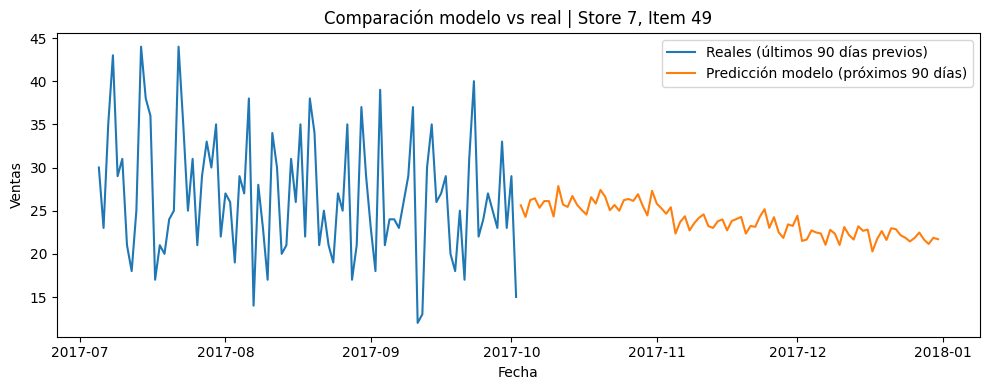

In [ ]:
best_model = keras.models.load_model("best_conv1d_tuned.h5")

DATA_DIR = "Data"
TRAIN_PATH = os.path.join(DATA_DIR, "train.csv")

train = pd.read_csv(TRAIN_PATH)
train["date"] = pd.to_datetime(train["date"])
train = train.sort_values(["store","item","date"]).reset_index(drop=True)

def winsorize_series(s, k=1.5):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lo, hi = q1 - k*iqr, q3 + k*iqr
    return s.clip(lower=lo, upper=hi)

train["sales_w"] = train.groupby(["store","item"])["sales"].transform(winsorize_series)
train["sales_log"] = np.log1p(train["sales_w"])
train["wday"] = (train["date"].dt.dayofweek + 1).astype(float)
train["sin_w"] = np.sin(2*np.pi*train["wday"]/7.0)
train["cos_w"] = np.cos(2*np.pi*train["wday"]/7.0)

feat_cols = ["sales_log","sin_w","cos_w"]
WINDOW_SIZE = 90
HORIZON = 90

val_start = train["date"].max() - pd.Timedelta(days=HORIZON - 1)

X_valid, y_valid, meta = [], [], []
for (st, it), g in train.groupby(["store","item"]):
    g = g.sort_values("date").reset_index(drop=True)
    if len(g) < WINDOW_SIZE + HORIZON:
        continue
    start = len(g) - (WINDOW_SIZE + HORIZON)
    Xv = g[feat_cols].values[start:start+WINDOW_SIZE]
    yv = g["sales_log"].values[start+WINDOW_SIZE:start+WINDOW_SIZE+HORIZON]
    X_valid.append(Xv)
    y_valid.append(yv)
    meta.append((st,it))

X_valid = np.array(X_valid, dtype=np.float32)
y_valid = np.array(y_valid, dtype=np.float32)
print("Series evaluadas:", len(X_valid), "| X_valid:", X_valid.shape, "| y_valid:", y_valid.shape)

y_pred_log = best_model.predict(X_valid, verbose=0)
y_true = np.expm1(y_valid)
y_pred = np.expm1(y_pred_log).clip(min=0)

def mae(a,b): return np.mean(np.abs(a-b))
def rmse(a,b): return np.sqrt(np.mean((a-b)**2))
def mape(a,b): return np.mean(np.abs((a-b)/np.maximum(a,1))) * 100

MAE = mae(y_true, y_pred)
RMSE = rmse(y_true, y_pred)
MAPE = mape(y_true, y_pred)
print(f"Validación Final (últimos 90 días del train)")
print(f"MAE  = {MAE:.2f}")
print(f"RMSE = {RMSE:.2f}")
print(f"MAPE = {MAPE:.2f}%")

idx = np.random.randint(0, len(X_valid))
st, it = meta[idx]
print(f"\nGráfica de predicción - Store {st}, Item {it}")

dates = train.query("store==@st and item==@it")["date"].values[-(HORIZON*2):]
real_vals = train.query("store==@st and item==@it")["sales"].values[-(HORIZON*2):]
pred_vals = y_pred[idx]

plt.figure(figsize=(10,4))
plt.plot(dates[:HORIZON], real_vals[:HORIZON], label="Reales (últimos 90 días previos)")
plt.plot(dates[HORIZON:], pred_vals, label="Predicción modelo (próximos 90 días)")
plt.title(f"Comparación modelo vs real | Store {st}, Item {it}")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.legend()
plt.tight_layout()
plt.show()


Considerando que el un modelo on un MAPE < 25% es bastance certero, nuestro modelo predice con un bajo error las ventas de las tiendas